In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_moons(n_samples=500, noise=0.1)

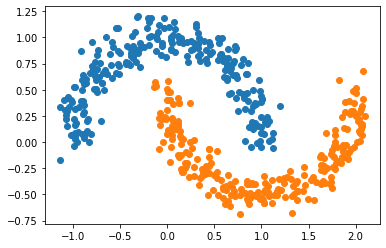

In [3]:
for i in range(len(np.unique(y))):
    plt.scatter(X[:, 0][y == i], X[:, 1][y == i])
plt.show()

In [4]:
def encode_y(y: np.ndarray) -> np.ndarray:
    n = np.max(y) + 1
    m = y.shape[0]
    y_encoded = np.zeros((m, n))
    for i, y_ in enumerate(y):
        y_encoded[i, y_] = 1
    return y_encoded

In [5]:
y_encoded = encode_y(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y)

# Helper functions

In [7]:
def ReLU(x: np.ndarray):
    return np.maximum(0, x)

def dReLU(x: np.ndarray):
    return np.where(x > 0, 1, 0)

def softmax(x: np.ndarray):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def categorical_crossentropy(y_pred: np.ndarray, y_true: np.ndarray):
    return - np.sum(y_pred * np.log(y_true + 1e-9), axis=1)

# Implementation

In [8]:
class NeuralNetwork:
    """
    Standard multi-layer neural network using ReLU and softmax as activation functions
    and categorical cross-entropy as cost function.
    
    Attributes
    ----------------
    _params: dict
        dictionary of all model parameters w = {w0, w1, ..., wn} 
        and b = {b0, b1, ..., bn}
    _grads : dict
        gradients for weights and biases to update parameters
    _cache : dict
        dictionary of all model outputs, to calculate gradients
        
    Methods
    -----------------
    fit(X, y, epochs, eta, batch_size)
        train neural network using stochastic gradient descent and batch-training
    predict(X)
        predict result using pretrained parameters
    __predict(x)
        predict result for one sample x
    __initialize parameters(input_size, units)
        initialize all model parameters
    __initialize_weights(input_size, output_size)
        initialize weights for one layer using kaiming method
    __get_batches(X, y, batch_size)
        generate batches for batch training
    __forward(x, with_grad)
        forward propagation, if with_grad, remember outputs 
    __linear_forward(x, w, b)
        calculate linear forward
    __backward(y_pred, y_true, eta)
        perform backpropagation
    __calculate_gradients(y_pred, y_true)
        calculate gradients using output of network, real class and caches
    __update_weights(eta)
        update weights using stochastic gradient method
    __calculate_cost(y_pred, y_true)
        calculate cost in current epoch
    __zero_grad()
        clear gradients and caches
    """
    
    def __init__(self, input_size: int, output_size: int, units: list or None = None):
        # parameters of the model
        self._params = dict()
        # gradients in the epoch
        self._grads = dict()
        # history of outputs, to calculate gradients
        self._cache = dict()
        # initialize all parameters
        if units:
            layers = [*units, output_size]
        else:
            layers = [output_size]
        self.__initialize_parameters(input_size, layers)
    
    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int, eta: float = 0.001, batch_size: int = 1):
        """
        Train neural net using stochastic gradient descent
        """
        loss = []
        for i in range(epochs):
            loss_epoch = []
            for x, y_true in self.__get_batches(X, y, batch_size):
                preds = self.__forward(x)
                loss_epoch.append(self.__calculate_cost(preds, y_true))
                self.__backward(preds, y_true, eta)
            loss.append(np.mean(loss_epoch))
        return loss
                    
                
    def predict(self, X: np.ndarray):
        """
        Predict for all samples
        """
        return np.array([self.__predict(x) for x in X])
    
    
    def __predict(self, x: np.ndarray):
        """
        Predict for one sample 
        """
        return np.argmax(self.__forward(x, with_grad=False))
    
        
    def __initialize_parameters(self, input_size: int, units: int):
        """
        Initialize all parameters
        """
        input_ = input_size
        for i, n_units in enumerate(units):
            w, b = self.__initialize_weights(input_, n_units)
            self._params[f'w_{i}'] = w
            self._params[f'b_{i}'] = b
            input_ = n_units
    
    def __initialize_weights(self, input_size: int, output_size: int):
        """
        Initialize weights and biases with given shape
        """
        w = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size) 
        b = np.random.randn(1, output_size) * np.sqrt(2.0 / input_size)
        return w, b
    
    def __get_batches(self, X: np.ndarray, y: np.ndarray, batch_size: int):
        """
        Divide dataset for batches
        """
        n_batches = len(y) // batch_size
        # arange indexes
        indexes = np.arange(0, len(y))
        np.random.shuffle(indexes)
        batches = np.array_split(indexes, n_batches)
        # concatenate
        return [(X[i], y[i]) for i in batches]
    
    def __forward(self, x: np.ndarray, with_grad: bool = True):
        """
        Compute results using forward propagation
        """
        input_ = x
        steps = len(self._params) // 2
        for i in range(steps):
            if with_grad:
                self._cache[f'x_{i}'] = input_
            w, b = self._params[f'w_{i}'], self._params[f'b_{i}']
            output_linear = self.__linear_forward(input_, w, b)
            if i < steps - 1:
                output = ReLU(output_linear)
                input_ = output
        output = softmax(output_linear)    
        return output
    
    def __linear_forward(self, x: np.ndarray, w: np.ndarray, b: np.ndarray):
        """
        Compute forward pass for one layer
        """
        return np.dot(x, w) + b
    
    def __backward(self, y_pred: np.ndarray, y_true: np.ndarray, eta: float):
        """
        Perform backpropagation
        """
        self.__calculate_gradients(y_pred, y_true)
        self.__update_weights(eta)
        self.__zero_grad()
    
    def __calculate_gradients(self, y_pred: np.ndarray, y_true: np.ndarray):
        """
        Calculate gradients for all weights and biases
        """
        # gradient of loss and softmax
        grad = (y_pred - y_true) 
        for i in range(len(self._params) // 2 - 1, -1, -1):
            w = self._params[f'w_{i}']
            x = self._cache[f'x_{i}']
            if len(x.shape) == 1:
                x = x.reshape(1, -1)
            dw = np.dot(x.T, grad)
            db = np.sum(grad)
            self._grads[f'w_{i}'] = dw
            self._grads[f'b_{i}'] = db
            grad = np.dot(grad, w.T) * dReLU(x)
    
    def __update_weights(self, eta: float):
        """
        Update parameters using stochastic gradient descent
        """
        for i in range(len(self._params) // 2):
            w, b = f'w_{i}', f'b_{i}'
            self._params[w] -= eta * self._grads[w]
            self._params[b] -= eta * self._grads[b]
            
    
    def __calculate_cost(self, y_pred: np.ndarray, y_true: np.ndarray):
        """
        Calculate cost function
        """
        return categorical_crossentropy(y_pred, y_true)
    
    def __zero_grad(self):
        """
        Clear the gradients and memory
        """
        self._cache.clear()
        self._grads.clear()

# Train model

In [9]:
# input_size = n_features, output_size = n_classes
n_features = 2
n_classes = 2
model = NeuralNetwork(input_size=n_features, output_size=n_classes, units=[28, 44, 28])

In [10]:
loss = model.fit(X_train, y_train, epochs=1000, eta=0.001, batch_size=2)

# Visualize results

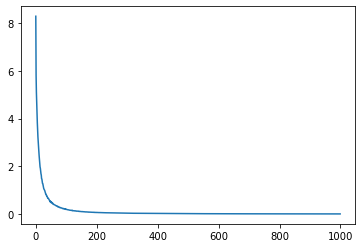

In [11]:
plt.plot(range(len(loss)), loss)
plt.show()

In [12]:
def accuracy(y_true, pred):
    i = 0
    j = 0
    for pred_, y in zip(pred, y_true):
        if np.argmax(y) == pred_:
            i += 1
        j += 1
    return i / j

In [13]:
pred = model.predict(X_test)
accuracy(y_test, pred)

1.0

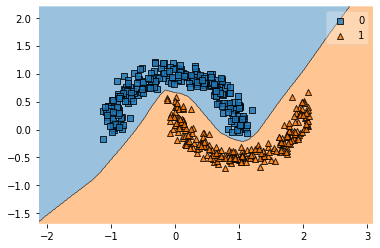

In [14]:
plot_decision_regions(X, y, model)
plt.show()